# Sample Based Interior/Edge Segmentation for 3D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno

import numpy as np

import deepcell

## Load the data

### Download the data from `deepcell.datasets`

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.
All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed` which is used to generate the random train-test split.
Metadata associated with the dataset can be accessed through the `metadata` attribute.

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'mousebrain.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = deepcell.datasets.mousebrain.load_data(filename, test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

1730158592/1730150850 [==============================] - 181s 0us/step
X.shape: (198, 15, 256, 256, 1)
y.shape: (198, 15, 256, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the Foreground/Background FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [5]:
frames_per_batch = 3
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 61  # should be adjusted for the scale of the data

In [6]:
# transform settings
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = True  # break edges into cell-background edge, cell-cell edge
pixelwise_kwargs = {
    'dilation_radius': dilation_radius,
    'separate_edge_classes': separate_edge_classes,
}

In [7]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_3D(
    receptive_field=receptive_field,
    n_features=2,
    norm_method=norm_method,
    n_frames=frames_per_batch,
    n_channels=X_train.shape[-1])

## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.

In [8]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'sample_fgbg_3d_model'
pixelwise_model_name = 'sample_edgeseg_3d_model'

n_epoch = 1  # Number of training epochs

lr = 0.01
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# Sample mode settings
batch_size = 64  # number of images per batch (should be 2 ^ n)
win = (receptive_field - 1) // 2  # sample window size
win_z = (frames_per_batch - 1) // 2 # z window size
balance_classes = True  # sample each class equally
max_class_samples = 1e6  # max number of samples per class.

### Create the DataGenerators

The `SampleMovieDataGenerator` generates many image patches of size `(2*win+1, 2*win+1, win_z)` to perform an image classification task for every pixel.

In [9]:
from deepcell.image_generators import SampleMovieDataGenerator

datagen = SampleMovieDataGenerator(
    rotation_range=180,
    zoom_range=(.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = SampleMovieDataGenerator()

In [10]:
fgbg_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    batch_size=batch_size,
    transform='fgbg',
    window_size=(win, win, win_z),
    balance_classes=balance_classes,
    max_class_samples=max_class_samples)

fgbg_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    batch_size=batch_size,
    transform='fgbg',
    window_size=(win, win, win_z),
    balance_classes=False,
    max_class_samples=max_class_samples)

In [11]:
pixelwise_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    batch_size=batch_size,
    transform='pixelwise',
    transform_kwargs=pixelwise_kwargs,
    window_size=(win, win, win_z),
    balance_classes=balance_classes,
    max_class_samples=max_class_samples)

pixelwise_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    batch_size=batch_size,
    transform='pixelwise',
    transform_kwargs=pixelwise_kwargs,
    window_size=(win, win, win_z),
    balance_classes=False,
    max_class_samples=max_class_samples)

### Compile the model with a loss function

Each model is trained with it's own loss function. `weighted_categorical_crossentropy` is often used for classification models, but `weighted_focal_loss` is also supported. The losses are passed to `model.compile` before training.

In [13]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=2,
        from_logits=False)

fgbg_model.compile(
    loss=loss_function,
    optimizer=SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

## Train the foreground/background model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [14]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(fgbg_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = fgbg_model.fit(
    fgbg_train_data,
    steps_per_epoch=fgbg_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=fgbg_val_data,
    validation_steps=fgbg_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
25000/25000 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9317
Epoch 00001: val_loss improved from inf to 0.15992, saving model to /data/models/sample_fgbg_3d_model.h5
25000/25000 [==============================] - 2649s 106ms/step - loss: 0.1923 - accuracy: 0.9317 - val_loss: 0.1599 - val_accuracy: 0.9423


## Create the `pixelwise` FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [15]:
from deepcell import model_zoo

pixelwise_model = model_zoo.bn_feature_net_3D(
    receptive_field=receptive_field,
    n_features=4 if separate_edge_classes else 3,
    n_frames=frames_per_batch,
    norm_method=norm_method,
    n_channels=X_train.shape[-1])

### Compile the model with a loss function

Just like the foreground/background model, the `pixelwise` model is compiled with the `weighted_categorical_crossentropy` loss function.

In [17]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=4 if separate_edge_classes else 3,
        from_logits=False)

pixelwise_model.compile(
    loss=loss_function,
    optimizer=SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

## Train the `pixelwise` model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [19]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(pixelwise_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(pixelwise_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = pixelwise_model.fit(
    pixelwise_train_data,
    steps_per_epoch=pixelwise_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=pixelwise_val_data,
    validation_steps=pixelwise_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
26677/40000 [===================>..........] - ETA: 22:32 - loss: 0.7048 - accuracy: 0.6879WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 40000 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 0.62215, saving model to /data/models/sample_edgeseg_3d_model.h5
26677/40000 [===================>..........] - 2870s 108ms/step - loss: 0.7048 - accuracy: 0.6879 - val_loss: 0.6222 - val_accuracy: 0.7672


## Predict on test data

The model was trained on small samples of data of shape `(frames_per_batch, receptive_field, receptive_field)`.
in order to process full-sized images, the trained weights will be saved and loaded into a new model with `dilated=True` and proper `input_shape`.

#### Save weights of trained models

In [20]:
fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
fgbg_model.save_weights(fgbg_weights_file)

pixelwise_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(pixelwise_model_name))
pixelwise_model.save_weights(pixelwise_weights_file)

#### Initialize dilated models and load the weights

In [21]:
from deepcell import model_zoo

run_fgbg_model = model_zoo.bn_feature_net_3D(
    receptive_field=receptive_field,
    dilated=True,
    n_features=2,
    n_frames=frames_per_batch,
    input_shape=tuple(X_test.shape[1:]))
run_fgbg_model.load_weights(fgbg_weights_file)

run_pixelwise_model = model_zoo.bn_feature_net_3D(
    receptive_field=receptive_field,
    dilated=True,
    n_features=4,
    n_frames=frames_per_batch,
    input_shape=tuple(X_test.shape[1:]))
run_pixelwise_model.load_weights(pixelwise_weights_file)

#### Make predictions on test data

In [22]:
test_images = run_pixelwise_model.predict(X_test[:4])
test_images_fgbg = run_fgbg_model.predict(X_test[:4])

print('edge/interior shape:', test_images.shape)
print('fgbg mask shape:', test_images_fgbg.shape)

edge/interior shape: (4, 15, 256, 256, 4)
fgbg mask shape: (4, 15, 256, 256, 2)


#### Post-processing

In [23]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

test_images_post_fgbg = test_images * fg_thresh

In [24]:
# Label interior predictions
from skimage.measure import label
from skimage import morphology

labeled_images = []
for i in range(test_images_post_fgbg.shape[0]):
    interior = test_images_post_fgbg[i, ..., 2] > .2
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=50, connectivity=1)
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1)

print('labeled_images shape:', labeled_images.shape)

labeled_images shape: (4, 15, 256, 256, 1)


Image: 1
Frame: 9


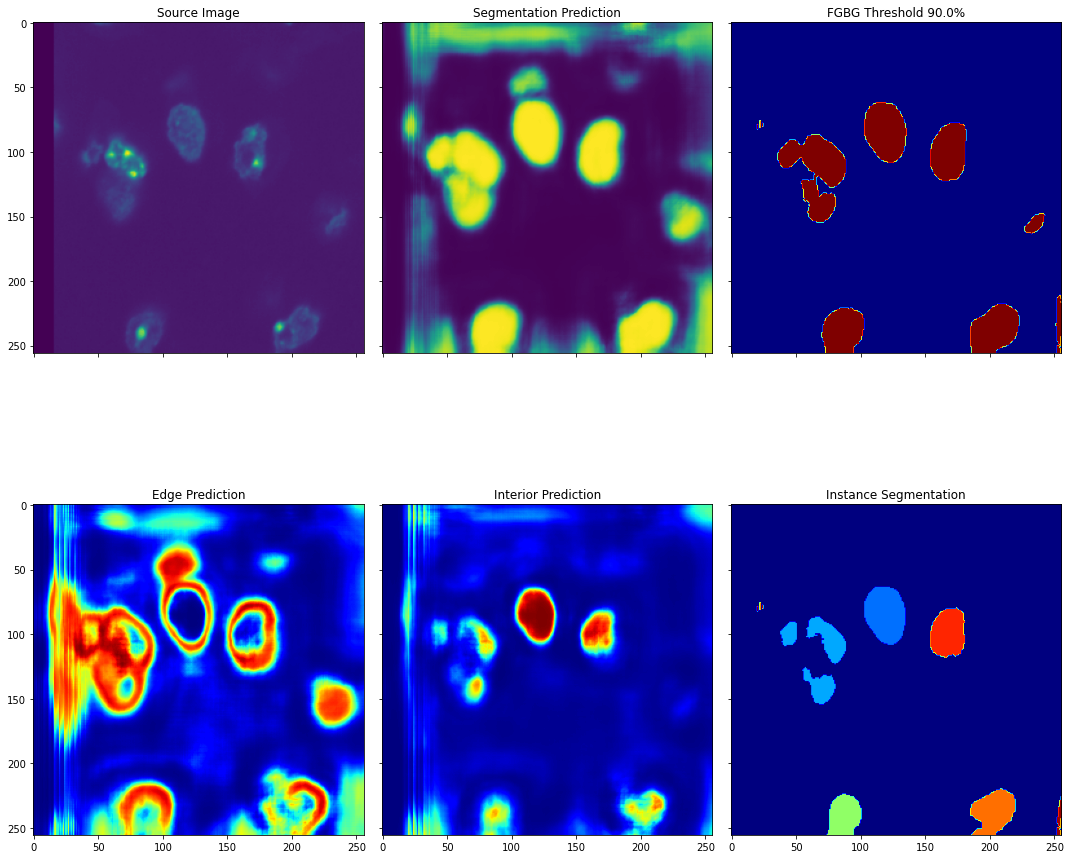

In [26]:
# Plot the results
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=labeled_images.shape[0])
frame = np.random.randint(low=0, high=labeled_images.shape[1])

print('Image:', index)
print('Frame:', frame)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(test_images[index, frame, ..., 0] + test_images[index, frame, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(test_images[index, frame, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')
fig.tight_layout()
plt.show()

In [27]:
from deepcell.utils.plot_utils import get_js_video
from IPython.display import HTML

HTML(get_js_video(labeled_images, batch=0, channel=0))